In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.path import Path as MplPath
from torch.utils.data import Dataset, DataLoader, random_split
import sys

# PyTorch (for later use)
import torch
import torch.nn as nn

# Path to your code module
sys.path.append('../../../code')
from load_data import load_full_match, load_team_matches, find_matches_with_360


| Channel | Name | Type | Description |
|---------|------|------|-------------|
| 1 | Teammates location | Sparse | 1 where attacking teammate exists |
| 2 | Opponents location | Sparse | 1 where opponent exists |
| 3 | Teammates velocity X | Sparse | X-velocity component |
| 4 | Teammates velocity Y | Sparse | Y-velocity component |
| 5 | Opponents velocity X | Sparse | X-velocity component |
| 6 | Opponents velocity Y | Sparse | Y-velocity component |
| 7 | Distance to ball | Dense | Distance from each cell to ball |
| 8 | Distance to goal | Dense | Distance from each cell to goal |
| 9 | Sin(angle) | Dense | Sine of goal-ball angle |
| 10 | Cos(angle) | Dense | Cosine of goal-ball angle |
| 11 | Angle to goal | Dense | Radians to goal |
| 12 | Sin(ball velocity) | Sparse | Sine of ball velocity angle |
| 13 | Cos(ball velocity) | Sparse | Cosine of ball velocity angle |
| 14 | Visibility mask | Dense | 1=visible, 0=not visible |

In [2]:
# Pitch dimensions CONSTANTS
PITCH_LENGTH = 120 
PITCH_WIDTH = 80

# Goal location (right side, center) - attacking direction is toward x=120
GOAL_LOCATION = [120, 40]  # [x, y] at center of right goal

print(f"Grid size: {PITCH_LENGTH} x {PITCH_WIDTH}")
print(f"Goal location: {GOAL_LOCATION}")

Grid size: 120 x 80
Goal location: [120, 40]


In [3]:
def get_grid_indices(x, y):
    """
    Convert StatsBomb coordinates to grid indices.
    No scaling - just clip to valid range.
    
    Args:
        x: X coordinate (0-120)
        y: Y coordinate (0-80)
    
    Returns:
        x_idx: Grid column index
        y_idx: Grid row index
    """
    x_idx = int(np.clip(round(x), 0, PITCH_LENGTH - 1))
    y_idx = int(np.clip(round(y), 0, PITCH_WIDTH - 1))
    return x_idx, y_idx


def get_event_data(expanded_df, event_id):
    """
    Extract event data, separating actor, teammates, and opponents.
    
    Args:
        expanded_df: Expanded freeze frame dataframe
        event_id: Event ID to extract
    
    Returns:
        dict with keys: 'actor', 'teammates', 'opponents', 'ball_location', 'end_location'
        or None if event not found
    """
    event_data = expanded_df[expanded_df["event_id"] == event_id]
    if event_data.empty:
        return None
    
    actor_row = event_data[event_data["actor"] == True]
    if actor_row.empty:
        return None
    
    actor = actor_row.iloc[0]
    
    return {
        'actor': actor,
        'teammates': event_data[(event_data["teammate"] == True) & (event_data["actor"] == False)],
        'opponents': event_data[event_data["teammate"] == False],
        'ball_location': actor["event_location"],
        'end_location': actor.get("end_location"),
        'event_data': event_data
    }

In [4]:
def create_channel_teammates_location(teammates):
    """
    Channel 1: Attacking teammates location (sparse).
    
    Args:
        teammates: DataFrame of teammate rows from freeze frame
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    channel = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    for _, row in teammates.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x_idx, y_idx = get_grid_indices(loc[0], loc[1])
            channel[y_idx, x_idx] += 1
    
    return channel


def create_channel_opponents_location(opponents):
    """
    Channel 2: Defending opponents location (sparse).
    
    Args:
        opponents: DataFrame of opponent rows from freeze frame
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    channel = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    for _, row in opponents.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x_idx, y_idx = get_grid_indices(loc[0], loc[1])
            channel[y_idx, x_idx] += 1
    
    return channel

In [5]:
def compute_player_velocities(expanded_df, event_id, max_time_gap=5.0, max_match_distance=15.0):
    """
    Compute player velocities by matching players across consecutive events.
    
    Since freeze frames don't have player IDs, we match players by:
    1. Same team status (teammate/opponent)
    2. Proximity (closest player within max_match_distance)
    
    Args:
        expanded_df: Expanded dataframe with freeze frame data
        event_id: Current event ID
        max_time_gap: Maximum time gap in seconds to look back (default 5.0)
        max_match_distance: Maximum distance to match a player (default 15.0 meters)
    
    Returns:
        velocity_dict: Dictionary mapping (team, teammate_status, df_index) -> [vx, vy]
    """
    # Get current event data
    current_event = expanded_df[expanded_df["event_id"] == event_id]
    if current_event.empty:
        return {}
    
    actor_row = current_event[current_event["actor"] == True]
    if actor_row.empty:
        return {}
    
    current_actor = actor_row.iloc[0]
    current_time = current_actor["minute"] * 60 + current_actor["second"]
    
    # Find previous event
    all_actors = expanded_df[expanded_df["actor"] == True].copy()
    all_actors["total_seconds"] = all_actors["minute"] * 60 + all_actors["second"]
    
    # Get events before current, within time window
    previous_events = all_actors[
        (all_actors["total_seconds"] < current_time) & 
        (all_actors["total_seconds"] >= current_time - max_time_gap)
    ].sort_values("total_seconds", ascending=False)
    
    if previous_events.empty:
        return {}
    
    # Use the most recent previous event
    previous_event_id = previous_events.iloc[0]["event_id"]
    previous_event = expanded_df[expanded_df["event_id"] == previous_event_id]
    
    if previous_event.empty:
        return {}
    
    previous_actor = previous_event[previous_event["actor"] == True].iloc[0]
    previous_time = previous_actor["minute"] * 60 + previous_actor["second"]
    
    time_delta = current_time - previous_time
    if time_delta <= 0 or time_delta > max_time_gap:
        return {}
    
    # Build velocity dictionary
    velocity_dict = {}
    
    # Get all players from current event (excluding actor)
    current_players = current_event[current_event["actor"] == False]
    
    # Get all players from previous event (excluding actor)
    previous_players = previous_event[previous_event["actor"] == False]
    
    # Match players by proximity and team status
    for curr_idx, curr_row in current_players.iterrows():
        curr_loc = curr_row["ff_location"]
        if not curr_loc or len(curr_loc) < 2:
            continue
        
        curr_teammate = curr_row["teammate"]
        curr_x, curr_y = curr_loc[0], curr_loc[1]
        
        # Find closest matching player in previous event
        best_match = None
        best_distance = float('inf')
        
        for prev_idx, prev_row in previous_players.iterrows():
            # Must be same team status
            if prev_row["teammate"] != curr_teammate:
                continue
            
            prev_loc = prev_row["ff_location"]
            if not prev_loc or len(prev_loc) < 2:
                continue
            
            prev_x, prev_y = prev_loc[0], prev_loc[1]
            distance = np.sqrt((curr_x - prev_x)**2 + (curr_y - prev_y)**2)
            
            if distance < best_distance and distance < max_match_distance:
                best_distance = distance
                best_match = (prev_x, prev_y)
        
        # Compute velocity if match found
        if best_match is not None:
            prev_x, prev_y = best_match
            
            # Velocity = displacement / time (meters per second)
            vx = (curr_x - prev_x) / time_delta
            vy = (curr_y - prev_y) / time_delta
            
            # Store velocity using current row's index as key
            key = (curr_row["team"], curr_teammate, curr_idx)
            velocity_dict[key] = [vx, vy]
    
    return velocity_dict

In [6]:
def create_channel_teammates_velocity(teammates, velocity_dict=None):
    """
    Channels 3-4: Attacking teammates velocity components (sparse).
    
    Args:
        teammates: DataFrame of teammate rows from freeze frame
        velocity_dict: Optional dict mapping player indices to [vx, vy]
    
    Returns:
        channel_vx: np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - X velocity
        channel_vy: np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - Y velocity
    """
    channel_vx = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    channel_vy = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    for idx, row in teammates.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x_idx, y_idx = get_grid_indices(loc[0], loc[1])
            
            vx, vy = 0.0, 0.0
            if velocity_dict is not None:
                key = (row["team"], row["teammate"], idx)
                if key in velocity_dict:
                    vx, vy = velocity_dict[key]
            
            channel_vx[y_idx, x_idx] = vx
            channel_vy[y_idx, x_idx] = vy
    
    return channel_vx, channel_vy

In [7]:
def create_channel_opponents_velocity(opponents, velocity_dict=None):
    """
    Channels 5-6: Defending opponents velocity components (sparse).
    
    Args:
        opponents: DataFrame of opponent rows from freeze frame
        velocity_dict: Optional dict mapping player indices to [vx, vy]
    
    Returns:
        channel_vx: np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - X velocity
        channel_vy: np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - Y velocity
    """
    channel_vx = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    channel_vy = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    for idx, row in opponents.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x_idx, y_idx = get_grid_indices(loc[0], loc[1])
            
            vx, vy = 0.0, 0.0
            if velocity_dict is not None:
                key = (row["team"], row["teammate"], idx)
                if key in velocity_dict:
                    vx, vy = velocity_dict[key]
            
            channel_vx[y_idx, x_idx] = vx
            channel_vy[y_idx, x_idx] = vy
    
    return channel_vx, channel_vy

In [8]:
def create_channel_distance_to_ball(ball_location):
    """
    Channel 7: Distance to ball (dense).
    
    Args:
        ball_location: [x, y] in StatsBomb coordinates
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    ball_x, ball_y = ball_location[0], ball_location[1]
    
    # Vectorized computation
    x_coords, y_coords = np.meshgrid(np.arange(PITCH_LENGTH), np.arange(PITCH_WIDTH))
    channel = np.sqrt((x_coords - ball_x)**2 + (y_coords - ball_y)**2)
    
    return channel

In [ ]:
def create_channel_distance_to_goal():
    """
    Channel 8: Distance to goal (dense).
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    goal_x, goal_y = GOAL_LOCATION
    
    x_coords, y_coords = np.meshgrid(np.arange(PITCH_LENGTH), np.arange(PITCH_WIDTH))
    channel = np.sqrt((x_coords - goal_x)**2 + (y_coords - goal_y)**2)
    
    return channel

In [10]:
def create_channel_angle_sin_cos(ball_location):
    """
    Channels 9-10: Sin and Cos of angle between location-to-goal and location-to-ball vectors.
    
    Args:
        ball_location: [x, y] in StatsBomb coordinates
    
    Returns:
        channel_sin: np.array of shape (PITCH_WIDTH, PITCH_LENGTH)
        channel_cos: np.array of shape (PITCH_WIDTH, PITCH_LENGTH)
    """
    channel_sin = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    channel_cos = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    ball_x, ball_y = ball_location[0], ball_location[1]
    goal_x, goal_y = GOAL_LOCATION
    
    for y_idx in range(PITCH_WIDTH):
        for x_idx in range(PITCH_LENGTH):
            # Vector from cell to goal
            vec_to_goal = [goal_x - x_idx, goal_y - y_idx]
            # Vector from cell to ball
            vec_to_ball = [ball_x - x_idx, ball_y - y_idx]
            
            mag_goal = np.sqrt(vec_to_goal[0]**2 + vec_to_goal[1]**2)
            mag_ball = np.sqrt(vec_to_ball[0]**2 + vec_to_ball[1]**2)
            
            if mag_goal > 0 and mag_ball > 0:
                # Normalize
                vec_goal_norm = [vec_to_goal[0] / mag_goal, vec_to_goal[1] / mag_goal]
                vec_ball_norm = [vec_to_ball[0] / mag_ball, vec_to_ball[1] / mag_ball]
                
                # Dot product for cos
                cos_angle = np.clip(
                    vec_goal_norm[0] * vec_ball_norm[0] + vec_goal_norm[1] * vec_ball_norm[1],
                    -1, 1
                )
                sin_angle = np.sqrt(1 - cos_angle**2)
                
                # Sign from cross product
                cross = vec_goal_norm[0] * vec_ball_norm[1] - vec_goal_norm[1] * vec_ball_norm[0]
                if cross < 0:
                    sin_angle = -sin_angle
                
                channel_sin[y_idx, x_idx] = sin_angle
                channel_cos[y_idx, x_idx] = cos_angle
    
    return channel_sin, channel_cos

In [11]:
def create_channel_angle_to_goal():
    """
    Channel 11: Angle to goal in radians (dense).
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    goal_x, goal_y = GOAL_LOCATION
    
    # Vectorized computation
    x_coords, y_coords = np.meshgrid(np.arange(PITCH_LENGTH), np.arange(PITCH_WIDTH))
    channel = np.arctan2(goal_y - y_coords, goal_x - x_coords)
    
    return channel

In [12]:
def create_channel_ball_velocity_angle(ball_location, end_location, teammates):
    """
    Channels 12-13: Sin/Cos of angle between ball velocity and direction to each teammate.
    
    Args:
        ball_location: [x, y] ball start position
        end_location: [x, y] ball end position (pass destination) or None
        teammates: DataFrame of teammate rows
    
    Returns:
        channel_sin: np.array of shape (PITCH_WIDTH, PITCH_LENGTH)
        channel_cos: np.array of shape (PITCH_WIDTH, PITCH_LENGTH)
    """
    channel_sin = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    channel_cos = np.zeros((PITCH_WIDTH, PITCH_LENGTH))
    
    ball_x, ball_y = ball_location[0], ball_location[1]
    
    # Check if end_location is valid
    if (end_location is None or 
        (isinstance(end_location, float) and np.isnan(end_location)) or
        not isinstance(end_location, (list, tuple, np.ndarray)) or 
        len(end_location) < 2):
        return channel_sin, channel_cos
    
    end_x, end_y = end_location[0], end_location[1]
    ball_velocity = [end_x - ball_x, end_y - ball_y]
    
    ball_vel_mag = np.sqrt(ball_velocity[0]**2 + ball_velocity[1]**2)
    if ball_vel_mag == 0:
        return channel_sin, channel_cos
    
    ball_vel_norm = [ball_velocity[0] / ball_vel_mag, ball_velocity[1] / ball_vel_mag]
    
    # For each teammate
    for _, row in teammates.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x_idx, y_idx = get_grid_indices(loc[0], loc[1])
            
            # Vector from ball to teammate
            vec_to_teammate = [loc[0] - ball_x, loc[1] - ball_y]
            vec_mag = np.sqrt(vec_to_teammate[0]**2 + vec_to_teammate[1]**2)
            
            if vec_mag > 0:
                vec_norm = [vec_to_teammate[0] / vec_mag, vec_to_teammate[1] / vec_mag]
                
                cos_angle = np.clip(
                    ball_vel_norm[0] * vec_norm[0] + ball_vel_norm[1] * vec_norm[1],
                    -1, 1
                )
                sin_angle = np.sqrt(1 - cos_angle**2)
                
                cross = ball_vel_norm[0] * vec_norm[1] - ball_vel_norm[1] * vec_norm[0]
                if cross < 0:
                    sin_angle = -sin_angle
                
                channel_sin[y_idx, x_idx] = sin_angle
                channel_cos[y_idx, x_idx] = cos_angle
    
    return channel_sin, channel_cos

In [13]:
def create_channel_visibility_mask(visible_area):
    """
    Channel 14: Visibility mask (dense).
    1 = visible, 0 = not visible.
    
    Args:
        visible_area: Flat list [x1, y1, x2, y2, ...] defining visible polygon
    
    Returns:
        np.array of shape (PITCH_WIDTH, PITCH_LENGTH) - 80x120
    """
    # If no valid visible area, assume entire pitch is visible
    if visible_area is None or len(visible_area) < 6 or len(visible_area) % 2 != 0:
        return np.ones((PITCH_WIDTH, PITCH_LENGTH))
    
    # Convert flat array to polygon points (already in StatsBomb coordinates)
    polygon_points = [
        (visible_area[i], visible_area[i+1]) 
        for i in range(0, len(visible_area), 2)
    ]
    
    # Create matplotlib Path
    polygon_path = MplPath(polygon_points)
    
    # Create grid of all points (vectorized)
    x_coords, y_coords = np.meshgrid(np.arange(PITCH_LENGTH), np.arange(PITCH_WIDTH))
    points = np.vstack([x_coords.ravel(), y_coords.ravel()]).T
    
    # Test all points
    inside = polygon_path.contains_points(points)
    channel = inside.reshape(PITCH_WIDTH, PITCH_LENGTH).astype(float)
    
    return channel

In [14]:
def create_14_channels(expanded_df, event_df, event_id, compute_velocities=True):
    """
    Create complete 14-channel representation for a single event.
    
    Args:
        expanded_df: Expanded dataframe with freeze frame data
        event_df: Event dataframe containing visible_area column
        event_id: Event ID to process
        compute_velocities: Whether to compute velocities (default True)
    
    Returns:
        channels: np.array of shape (14, PITCH_WIDTH, PITCH_LENGTH) = (14, 80, 120)
        or None if event not found
    """
    # Extract event data
    data = get_event_data(expanded_df, event_id)
    if data is None:
        return None
    
    teammates = data['teammates']
    opponents = data['opponents']
    ball_location = data['ball_location']
    end_location = data['end_location']
    
    # Get visible_area from event_df
    event_row = event_df[event_df["event_id"] == event_id]
    visible_area = None
    if not event_row.empty and "visible_area" in event_row.columns:
        visible_area = event_row.iloc[0]["visible_area"]
    
    # Compute velocities if requested
    velocity_dict = None
    if compute_velocities:
        velocity_dict = compute_player_velocities(expanded_df, event_id)
    
    # Initialize channels array: (14, 80, 120)
    channels = np.zeros((14, PITCH_WIDTH, PITCH_LENGTH))
    
    # Channel 1: Teammates location
    channels[0] = create_channel_teammates_location(teammates)
    
    # Channel 2: Opponents location
    channels[1] = create_channel_opponents_location(opponents)
    
    # Channels 3-4: Teammates velocity (now uses computed velocity_dict)
    channels[2], channels[3] = create_channel_teammates_velocity(teammates, velocity_dict)
    
    # Channels 5-6: Opponents velocity (now uses computed velocity_dict)
    channels[4], channels[5] = create_channel_opponents_velocity(opponents, velocity_dict)
    
    # Channel 7: Distance to ball
    channels[6] = create_channel_distance_to_ball(ball_location)
    
    # Channel 8: Distance to goal
    channels[7] = create_channel_distance_to_goal()
    
    # Channels 9-10: Sin/Cos angle
    channels[8], channels[9] = create_channel_angle_sin_cos(ball_location)
    
    # Channel 11: Angle to goal
    channels[10] = create_channel_angle_to_goal()
    
    # Channels 12-13: Ball velocity angle
    channels[11], channels[12] = create_channel_ball_velocity_angle(ball_location, end_location, teammates)
    
    # Channel 14: Visibility mask
    channels[13] = create_channel_visibility_mask(visible_area)
    
    return channels

In [15]:
# Load a sample match
BASE_DIR = "../../../data/open-data/data"
MATCH_ID = "3895302"  # Sample Leverkusen match

print(f"Loading match {MATCH_ID}...")
event_df, expanded_df, lineup_lookup = load_full_match(MATCH_ID, base_dir=BASE_DIR)

print(f"Events: {len(event_df)}")
print(f"Freeze frame rows: {len(expanded_df)}")

# Get a sample pass event with freeze frame data
pass_events = expanded_df[(expanded_df["event_type"] == "Pass") & (expanded_df["actor"] == True)]
sample_event_id = pass_events["event_id"].iloc[10]

# Get event details
event_info = event_df[event_df["event_id"] == sample_event_id].iloc[0]
print(f"\nSample Event: {sample_event_id[:8]}...")
print(f"  Type: {event_info['type']}")
print(f"  Player: {event_info['player']}")
print(f"  Team: {event_info['team']}")
print(f"  Minute: {event_info['minute']}:{event_info['second']:02d}")
print(f"  Location: {event_info['location']}")
print(f"  End Location: {event_info.get('end_location')}")

Loading match 3895302...
Events: 4223
Freeze frame rows: 56319

Sample Event: ba58c1f0...
  Type: Pass
  Player: Robert Andrich
  Team: Bayer Leverkusen
  Minute: 0:28
  Location: [38.1, 19.5]
  End Location: [29.9, 19.5]


In [16]:
# Create 14 channels for sample event
channels = create_14_channels(expanded_df, event_df, sample_event_id)

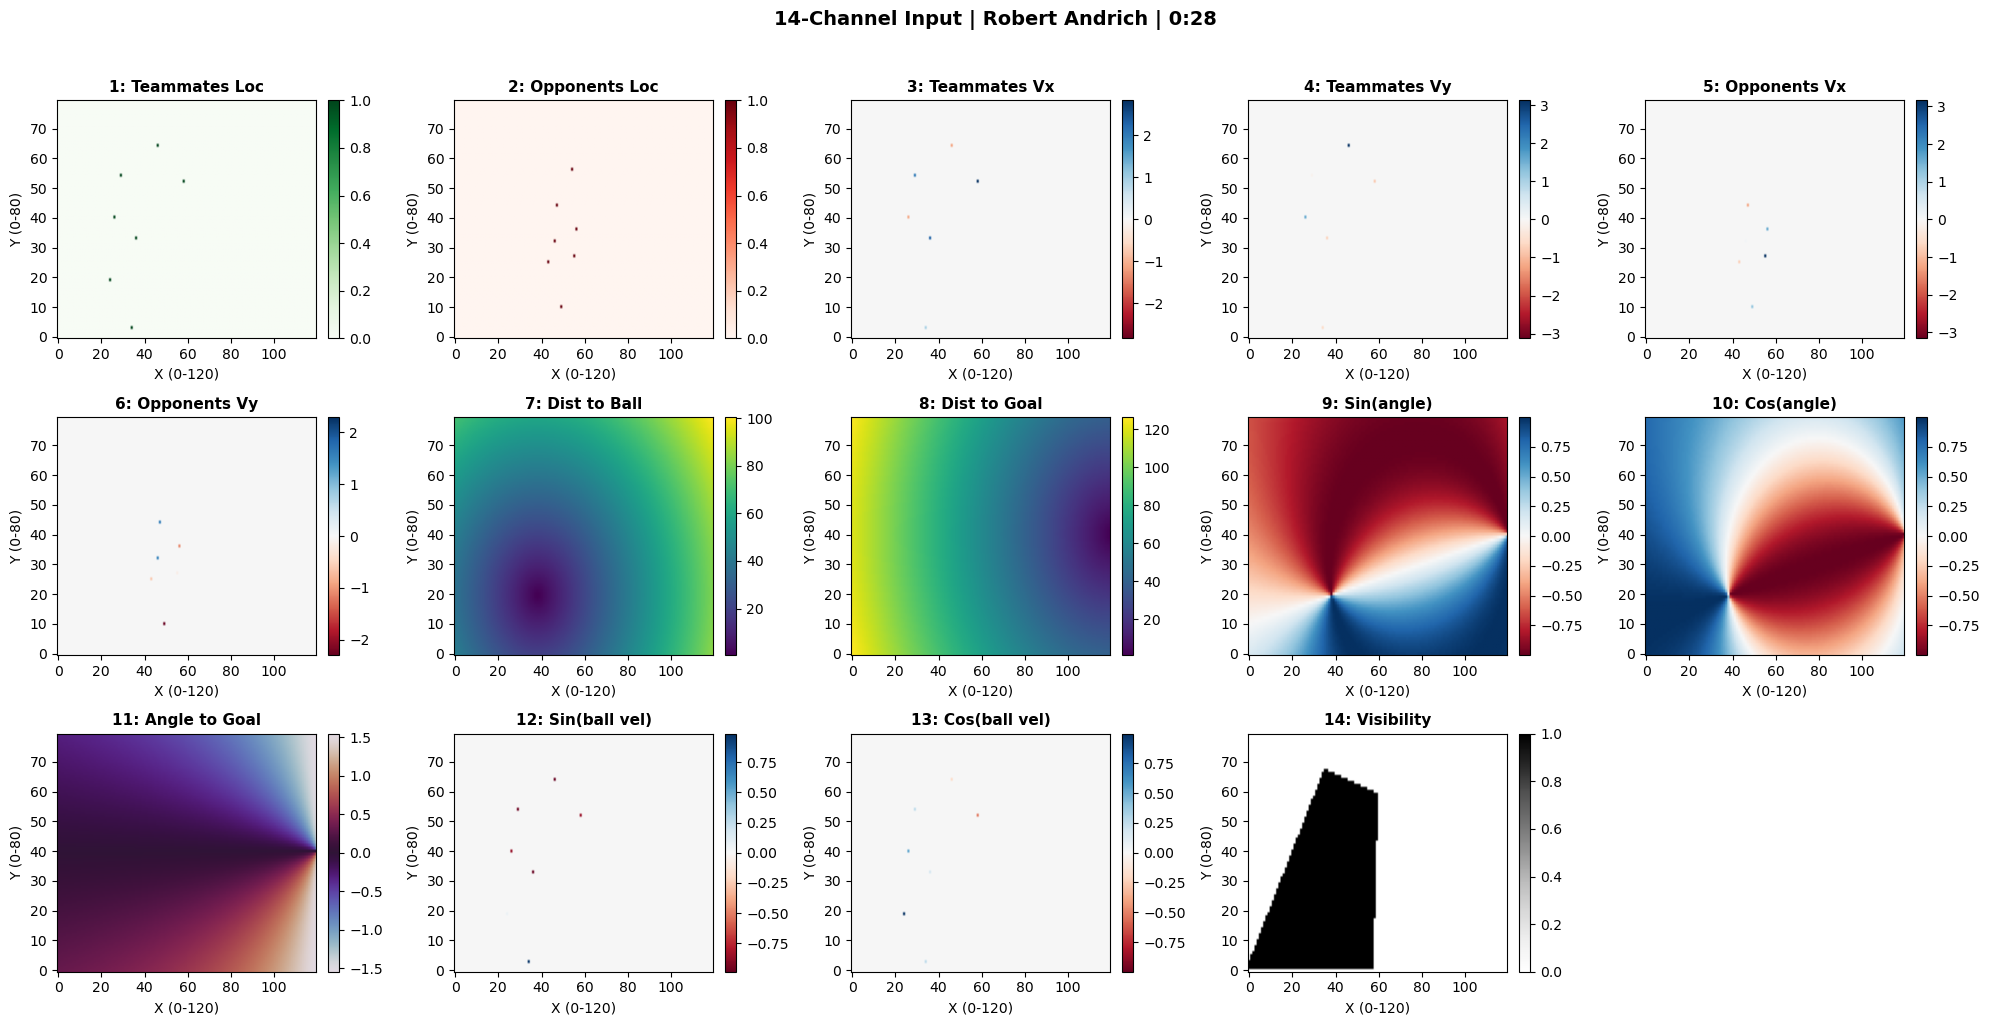

In [17]:
# Visualize all 14 channels in a grid
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

channel_names_short = [
    "1: Teammates Loc",
    "2: Opponents Loc",
    "3: Teammates Vx",
    "4: Teammates Vy",
    "5: Opponents Vx",
    "6: Opponents Vy",
    "7: Dist to Ball",
    "8: Dist to Goal",
    "9: Sin(angle)",
    "10: Cos(angle)",
    "11: Angle to Goal",
    "12: Sin(ball vel)",
    "13: Cos(ball vel)",
    "14: Visibility"
]

# Different colormaps for different channel types
cmaps = [
    'Greens',   # 1: Teammates (green = friendly)
    'Reds',     # 2: Opponents (red = opponent)
    'RdBu',     # 3: Velocity X (diverging)
    'RdBu',     # 4: Velocity Y (diverging)
    'RdBu',     # 5: Velocity X (diverging)
    'RdBu',     # 6: Velocity Y (diverging)
    'viridis',  # 7: Distance to ball
    'viridis',  # 8: Distance to goal
    'RdBu',     # 9: Sin (diverging, -1 to 1)
    'RdBu',     # 10: Cos (diverging, -1 to 1)
    'twilight', # 11: Angle (circular)
    'RdBu',     # 12: Sin (diverging)
    'RdBu',     # 13: Cos (diverging)
    'Greys',    # 14: Visibility (binary)
]

for i in range(14):
    ax = axes[i]
    
    # Use diverging colormap centered at 0 for sin/cos
    if i in [2, 3, 4, 5, 8, 9, 11, 12]:  # Diverging channels
        vmax = max(abs(channels[i].min()), abs(channels[i].max()))
        if vmax == 0:
            vmax = 1
        im = ax.imshow(channels[i], origin='lower', cmap=cmaps[i], 
                       vmin=-vmax, vmax=vmax, aspect='auto')
    else:
        im = ax.imshow(channels[i], origin='lower', cmap=cmaps[i], aspect='auto')
    
    ax.set_title(channel_names_short[i], fontsize=11, fontweight='bold')
    ax.set_xlabel('X (0-120)')
    ax.set_ylabel('Y (0-80)')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide the 15th subplot
axes[14].axis('off')

# Get event details for title
event_info = event_df[event_df["event_id"] == sample_event_id].iloc[0]
player = event_info['player']
minute = event_info['minute']
second = event_info['second']

plt.suptitle(f"14-Channel Input | {player} | {minute}:{second:02d}", 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    """Conv2D + BatchNorm + ReLU block."""
    
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


class SoccerMap(nn.Module):
    """
    Faithful SoccerMap implementation based on the paper.
    
    Key features:
    - Uses nearest neighbor upsampling (not bilinear)
    - Uses 1×1 convolutions for predictions
    - Multi-scale predictions fused via concatenation + 1×1 conv
    - Decoder paths that refine features before prediction
    """
    
    def __init__(self, in_channels=14):
        super(SoccerMap, self).__init__()
        
        # Level 1: Full resolution
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Level 2: Half resolution
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Level 3: Quarter resolution
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # upsampling
        # Level 3 -> Level 2
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Combine up3 output with enc2 skip connection
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),  # 64 from up3 + 64 from enc2
            nn.ReLU(inplace=True),
        )
        
        # Level 2 -> Level 1
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Combine up2 output with enc1 skip connection
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 32, 32, kernel_size=3, padding=1),  # 32 from up2 + 32 from enc1
            nn.ReLU(inplace=True),
        )
        
        # prediction
        self.pred3 = nn.Sequential(
            nn.Conv2d(128, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
        )
        
        self.pred2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
        )
        
        self.pred1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1),
        )
        
        # fusion
        self.fusion = nn.Conv2d(3, 1, kernel_size=1)
        
        # Sigmoid 
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        input_size = x.shape[2:]  # (H, W)
            
        # encoder
        enc1 = self.enc1(x)      
        enc2 = self.enc2(self.pool1(enc1))  
        enc3 = self.enc3(self.pool2(enc2))  
        
        # decoder
        # Level 3 -> Level 2
        up3 = self.up3(enc3)                 
        dec2 = self.dec2(torch.cat([up3, enc2], dim=1))
        
        # Level 2 -> Level 1
        up2 = self.up2(dec2)               
        dec1 = self.dec1(torch.cat([up2, enc1], dim=1)) 
        
        # predictions
        # Predictions from decoder outputs (refined features)
        pred3 = self.pred3(enc3)  
        pred2 = self.pred2(dec2) 
        pred1 = self.pred1(dec1) 
        
        pred3_up = F.interpolate(pred3, size=input_size, mode='nearest')
        pred2_up = F.interpolate(pred2, size=input_size, mode='nearest')
        
        fused = torch.cat([pred1, pred2_up, pred3_up], dim=1)
        output = self.fusion(fused) 
        output = self.sigmoid(output)
        
        return output


import torch.nn.functional as F

model = SoccerMap(in_channels=14)

test_input = torch.randn(2, 14, 80, 120)
test_output = model(test_input)

print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.min():.4f}, {test_output.max():.4f}]")

params = sum(p.numel() for p in model.parameters())
print(f"Parameters:   {params:,}")


Input shape:  torch.Size([2, 14, 80, 120])
Output shape: torch.Size([2, 1, 80, 120])
Output range: [0.5217, 0.5298]
Parameters:   482,055


In [19]:
TEAM_NAME = "Bayer Leverkusen"
COMPETITION_ID = 9      # Bundesliga
SEASON_ID = 281         # 2023/24 season
BASE_DIR = "../../../data/open-data/data"

matches = load_team_matches(
    team_name=TEAM_NAME,
    competition_id=COMPETITION_ID,
    season_id=SEASON_ID,
    base_dir=BASE_DIR
)
matches_with_360 = find_matches_with_360(matches, base_dir=BASE_DIR)

In [20]:
from tqdm import tqdm 


# Load all events and freeze frames
all_event_dfs = []
all_expanded_dfs = []

match_ids_to_load = [m["match_id"] for m in matches if m["match_id"] in matches_with_360]
print(f"Loading {len(match_ids_to_load)} matches...")

iterator = tqdm(match_ids_to_load)

for match_id in iterator:
    event_df, expanded_df, lineup = load_full_match(str(match_id), base_dir=BASE_DIR)
    
    # Filter for Leverkusen events only
    lev_events = event_df[event_df["team"].str.contains("Leverkusen", case=False, na=False)].copy()
    lev_expanded = expanded_df[expanded_df["team"].str.contains("Leverkusen", case=False, na=False)].copy()
    
    # Add match_id column if not present
    if "match_id" not in lev_events.columns:
        lev_events["match_id"] = match_id
    if "match_id" not in lev_expanded.columns:
        lev_expanded["match_id"] = match_id
    
    all_event_dfs.append(lev_events)
    all_expanded_dfs.append(lev_expanded)

combined_event_df = pd.concat(all_event_dfs, ignore_index=True)
combined_expanded_df = pd.concat(all_expanded_dfs, ignore_index=True)

print(f"\nTotal Leverkusen events: {len(combined_event_df):,}")
print(f"Total freeze frame rows: {len(combined_expanded_df):,}")

Loading 34 matches...


100%|██████████| 34/34 [00:13<00:00,  2.44it/s]


Total Leverkusen events: 81,440
Total freeze frame rows: 1,181,537


In [63]:
pass_events_df = combined_event_df[combined_event_df["type"] == "Pass"].copy()

valid_passes = pass_events_df[
    pass_events_df["end_location"].apply(
        lambda x: x is not None and isinstance(x, (list, tuple, np.ndarray)) and len(x) >= 2
    )
].copy()

pass_event_ids = valid_passes["event_id"].unique().tolist()

['b8ea5d17-518b-4f87-86cf-557d57345a23',
 '147de3eb-2cae-479d-be6f-e0e1e2dc30de',
 '1d43d9bb-9f3e-4ee1-85c8-1773543caa18',
 'ba58c1f0-2eb3-4a70-86e3-50cea43cb3b8',
 '029cd118-dc2a-4e3d-aa44-39288ac3e700',
 '75b4f810-0483-47f7-b87f-dfab064b2781',
 'cd460252-ecf1-4f5e-a65e-f2919175a0f2',
 'a537b2d8-6895-4165-9a61-16af0ac6c9da',
 '3201ceee-1a9f-41f6-9573-0c4e53eeb850',
 '12ac4b64-8bdc-41e0-a23a-71d9ebe7dc0a',
 'ea722a93-4143-448b-aaeb-66d37e41690d',
 '7a9e0311-6936-4f6d-aa56-90c0e6ff7b58',
 'bd813572-a87b-40ac-bf56-ab3b95c6fbe1',
 '961a0a17-d54b-4059-a1ef-a2860e5579d7',
 '01817480-a223-4835-861f-9feb7227d63c',
 '5fe923a5-aaa7-45fd-87cc-0538660db639',
 'dd8016fa-867b-47b2-b0e5-cb57b9ef53b4',
 '3d4abe17-e64b-4535-89b6-51ae231a8f93',
 '20012729-16de-4f46-9949-ef274a9a876f',
 'c4a55dda-7658-4981-85b0-6f5378401915',
 '00d4f1f8-9c99-4639-bee6-b1dc29b5ffff',
 '8f056266-8332-421a-8c80-86bf0506a5c1',
 'c071379d-51d7-451d-bcc1-88ac54f3056f',
 'cd7ff218-1942-4c73-9f4f-d5bc55020895',
 '42bea50c-4562-